## Loading Libraries and Directories
This is a Tutorial made for the secondary structure determination using Gradient Descent method.

One should be able to run it without knowing python by just following the instructions given in the text fields.

In places where the code lines are hidden, one can click "Show code" to reveal them.


<div>
<img src="https://drive.google.com/uc?id=17xv3BIfWV3M7fNWHbaNjbaNnbDQa7QtV" width="800"/>
</div>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title  { run: "auto", vertical-output: true, display-mode: "form" }
Directory = "/content/drive/MyDrive/GDMC" #@param {type:"string"}
#@markdown Here, all relevant libraries are imported and installed. In the field, one needs to specify the path to the folder that contains the spectrum csv file. Please make sure Google Drive is connected when using Colab notebook.
from google.colab import files
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import math
import pandas as pd
from collections import deque
import os
from IPython.display import clear_output
import random
from tqdm.notebook import trange
from bs4 import BeautifulSoup
import requests
import math
import pandas as pd
import sqlite3
import scipy.stats
device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.chdir(Directory +'/References')


# Gradient Descent Determining Distribution

## **NMR Data Preparation:** Using Real Spectrum
Expand cell to see details

In [ ]:
#@title Step 1. Load File { vertical-output: true }
data_file_name = "/content/drive/MyDrive/GDMC/References/ubiquitin_60MHz.csv" #@param {type:"string"}
Print_Chosen_Column_Content = "Yes" #@param ["Yes", "No"]
column_number =  2#@param {type:"integer"}
#@markdown If chosen "Yes" for **Print_Column_Content**, the column values with **column_number** will be concatenated and displayed. This could be used for getting a sequence that is written in the file.



data_ca = pd.read_csv(data_file_name)
print('The csv file has the following column names:')
for i,j in enumerate(data_ca.columns):
  print('---------------------------------')
  print('Column' + str(i) + ':',j)

if(Print_Chosen_Column_Content == 'Yes'):
  try:
    columns = data_ca.columns
    column_name = columns[column_number]
    start = ''

    for i in data_ca[column_name].values:
      try:
        if(i.isalpha()):
          start += str(i)
      except:
        break

    if(len(start) < 600):
      print('\n')
      print(start)
    #else:
      #print('\n')
      #print('Column with sequence greater than 400 will not be printed')
  except:
    print('Error Occured. Check Column Number.')

The csv file has the following column names:
---------------------------------
Column0: ppm
---------------------------------
Column1: ubiquitin
---------------------------------
Column2: seq


MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG


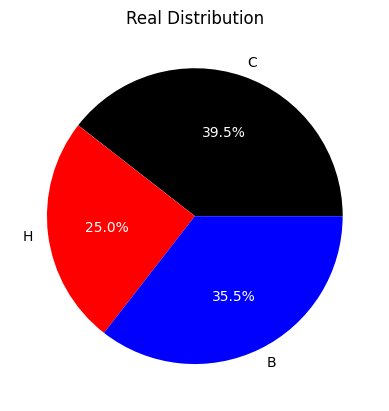

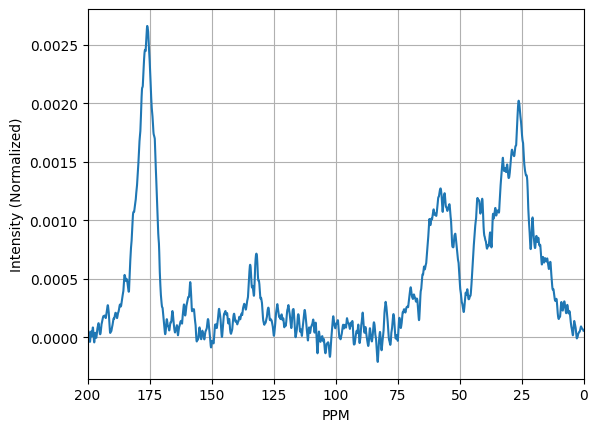

-------------------Completed Data Preparation-----------------------


<ipython-input-26-d81eee83f1a7>:193: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_possible_shifts[i,j,k] = val


In [ ]:
#@title Step 2. Selecting Relevant Information
#@title  { run: "auto", vertical-output: true, display-mode: "form" }
#@title  { run: "auto", display-mode: "form" }
#@title  { display-mode: "form" }
#@markdown To use a real spectrum, within the "Reference" folder, drop the ".csv" file that contains the shift data with columns that corresponds to the ppm values and intensities.
Manual_Sequence_Input = "Yes" #@param ["Yes", "No"]

FASTA_Sequence = "MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG" #@param {type:"string"}
Seq_Use_Column = 2#@param {type:"integer"}
Show_Real_SS = "Yes" #@param ["Yes", "No"]
Manual_SS_Input = "Yes" #@param ["Yes", "No"]
Real_SS = "CEEEEEETTTEEEEEECTTTTBHHHHHHHHHHHHCCCGGGEEEEETTEECTTTTBGGGGCCTTTTEEEEEECCCCC" #@param {type:"string"}
SS_Use_Column = 4#@param {type:"integer"}

PPM_axis_name = "ppm" #@param {type:"string"}
min_ppm =  0#@param {type:"number"}
max_ppm =  200#@param {type:"number"}
#@markdown The **min_ppm** and **max_ppm** controls the ppm intervals of the spectrum to be fitted
Exclude_Aromatic_Side_Chain = "No" #@param ["Yes", "No"]
side_ppm_min =  85#@param {type:"number"}
side_ppm_max =  167#@param {type:"number"}

#@markdown If **Exclude_Aromatic_Side_Chain** is "Yes" the region between **side_ppm_min** and **side_ppm_max** will not be fitted.

Intensity_axis_name = "ubiquitin" #@param {type:"string"}
Re_reference =  -2.4#@param {type:"number"}
Mode_vs_Mean = "Mode Shift" #@param ["Mode Shift", "Mean Shift"]
Negative_Correction_Method = "Mean-Negative" #@param ["Mean-Negative", "Absolute"]


# Ubiquitin:MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG
# GB1:MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
# 2QMT:   CEEEEEEETTTTEEEEEEECCCHHHHHHHHHHHHHHHCCCCEEEEETTTTEEEEEC
# Manual: BBBBBBBBCCCCBBBBBBBBCHHHHHHHHHHHHHHHHCCCCEEEEEECCBBBBBBB
SS = np.array(["C","H","B"])



if(Manual_Sequence_Input == 'Yes'):
    sequence = np.array([s.upper() for s in FASTA_Sequence],dtype = str)
else:
    try:
        columns = data_ca.columns
        column_name = columns[Seq_Use_Column]
        start = ''

        for i in data_ca[column_name].values:
            try:
                if(i.isalpha()):
                    start += str(i)
            except:
                break

    except:
        print('Error Occured. Check Sequence Column Number.')

    sequence = start
    print('Selected Sequence From Column:', sequence)
    sequence = np.array([s.upper() for s in sequence],dtype = str)




if(Show_Real_SS == 'Yes'):
    if(Manual_SS_Input == 'Yes'):
        real_ss = np.array([s for s in Real_SS])
        real_ss[real_ss == 'G'] = 'H'
        real_ss[real_ss == 'I'] = 'H'
        real_ss[real_ss == 'E'] = 'B'
        real_ss[real_ss == 'T'] = 'C'
        real_ss[real_ss == 'b'] = 'B'
        real_ss[real_ss == '-'] = 'C'
        distribution = [(real_ss == 'C').sum()/len(real_ss),(real_ss == 'H').sum()/len(real_ss),(real_ss == 'B').sum()/len(real_ss)]
        colors = ['black', 'red', 'blue']
        plt.figure(dpi = 100)
        _, _, autotexts = plt.pie(distribution, explode=[0.001,0,0], labels=SS, autopct='%1.1f%%',colors = colors);
        for autotext in autotexts:
            autotext.set_color('white')
        plt.title('Real Distribution');
        plt.savefig('/content/real_ss.eps')
        plt.show()
    else:
        try:
            columns = data_ca.columns
            column_name = columns[SS_Use_Column]
            start = ''

            for i in data_ca[column_name].values:
                try:
                    if(i.isalpha()):
                        start += str(i)
                except:
                    break

        except:
            print('Error Occured. Check Sequence Column Number.')
        real_ss = start
        print('Selected SS From Column:', real_ss)
        real_ss = np.array([s for s in real_ss])
        real_ss[real_ss == 'G'] = 'H'
        real_ss[real_ss == 'I'] = 'H'
        real_ss[real_ss == 'E'] = 'B'
        real_ss[real_ss == 'T'] = 'C'
        real_ss[real_ss == 'b'] = 'B'
        real_ss[real_ss == '-'] = 'C'
        distribution = [(real_ss == 'C').sum()/len(real_ss),(real_ss == 'H').sum()/len(real_ss),(real_ss == 'B').sum()/len(real_ss)]
        colors = ['black', 'red', 'blue']
        plt.figure(dpi = 100)
        _, _, autotexts = plt.pie(distribution, explode=[0.001,0,0], labels=SS, autopct='%1.1f%%',colors = colors);
        for autotext in autotexts:
            autotext.set_color('white')
        plt.title('Real Distribution');
        plt.savefig('/content/real_ss.eps')
        plt.show()

    if(len(sequence) != len(real_ss)):
        print('WARNING: length of sequence ('+ str(len(sequence))+ ') does not equal to length of secondary structures (' + str(len(real_ss)) + ')!')


ppm = data_ca[PPM_axis_name].values - Re_reference
real_spectrum = data_ca[Intensity_axis_name].values

index1 = (ppm > min_ppm)
index2 = (ppm < max_ppm)
index = index1*index2 # Indexing the range of data to minimize noise

if(Exclude_Aromatic_Side_Chain == 'Yes'):
  index1_ = (ppm < side_ppm_min)
  index2_ = (ppm > side_ppm_max)
  index_ = index1_ | index2_
  index =  index*index_
else:
  pass

real_spectrum = real_spectrum[index]
ppm = ppm[index]

negative_inds = (real_spectrum < 0)
if(np.sum(negative_inds) > 1):
  if(Negative_Correction_Method == 'Mean-Negative'):
    mean_negative = real_spectrum[negative_inds].mean()
    real_spectrum = real_spectrum - mean_negative # Correcting the negative part of the initial spectrum
  elif(Negative_Correction_Method == 'Absolute'):
    real_spectrum[negative_inds] = np.abs(real_spectrum[negative_inds])
  else:
    print('Spectrum Negative Correction Error')

plt.figure(dpi = 100)
plt.grid()
plt.plot(ppm,real_spectrum)
plt.xlabel('PPM')
plt.xlim(max_ppm,min_ppm)
plt.ylabel('Intensity (Normalized)')
plt.show()


real_spectrum = real_spectrum/real_spectrum.sum() # Normalization

#initialization = torch.zeros((len(sequence), 3),dtype = torch.float32) # Specifying initial guess
#initialization[:,0] = 3
initialization = None # Do not use a specific guess of initial state, start with equal mixture



shift_table = pd.read_csv('Shift Table.txt',sep=',', header=None)

shift_table = shift_table.rename({0:'Res Name', 1:'Atom Type', 2:'Secondary Structure', 3:'Mode Shift',4:'Mean Shift', 5: 'STD', 6:'Min Shift',7:'Max Shift'},axis = 1)

side_chain_table = pd.read_csv('side_chain_shifts.csv')
side_chain_table = side_chain_table.rename({'Amino Acid':'Res Name','CN2':'CH2'},axis = 1)
new_index = side_chain_table['Res Name'] # Use residue name as index
side_chain_table = side_chain_table.set_index(new_index)

all_table_ss = shift_table['Secondary Structure'].values
all_table_ss[all_table_ss == 'E'] = 'B' # Replacing the notation of beta-sheet from E to B
shift_table['Secondary Structure'] = all_table_ss

atom_types = ['CA','CB','C']
SS = np.array(['C', 'H', 'B'])
residue_types = np.unique(shift_table['Res Name'].values)

all_possible_shifts = np.nan*np.zeros((len(residue_types),len(atom_types),len(SS))) # This is the vector that contain all possible shifts [Res type, atom type, SS type]

for i in range(len(residue_types)):
  entry = shift_table[shift_table['Res Name'] == residue_types[i]]
  for j in range(len(atom_types)):
    sub_entry = entry[entry['Atom Type'] == atom_types[j]]


    if(len(sub_entry) >= 3): # If has at least alpha, beta and coil three types
      for k in range(len(SS)):
        val = sub_entry[sub_entry['Secondary Structure'] == SS[k]][Mode_vs_Mean].values
        all_possible_shifts[i,j,k] = val


data_shift_table = np.zeros((len(sequence),len(atom_types),len(SS))) # Filling up the data table (CA, CB, C)
ind = 0
for res in sequence:
  data_shift_table[ind] = all_possible_shifts[np.argwhere(residue_types == res)]

  ind += 1

# Here we are running a separate list that is going to be initialized as te background of the spectra


backbone_means = []
for residue in sequence:
  residue_side_chain_table = side_chain_table.loc[residue].values[1:].astype(float)
  has_side_atom = ~np.isnan(residue_side_chain_table)
  for shift in residue_side_chain_table[has_side_atom]:
    backbone_means.append(shift)
backbone_means = np.array(backbone_means) # Side-chain shifts that will be used as background
print('-------------------Completed Data Preparation-----------------------')




## Running GD

In [ ]:
#@title Running GD with parameters { display-mode: "form" }
Epochs =  100#@param {type:"integer"}
Learning_rate =  0.1#@param {type:"number"}
#@markdown Usually the loss converges in 100 epochs with a learning rate of 0.1
Freedom_ppm_back =  0#@param {type:"number"}
Freedom_ppm_side =  0#@param {type:"number"}
#@markdown **Freedom_ppm_back** and **Freedom_ppm_side** work on shifts for backbone and side-chain carbons. Outside of the Freedom_ppm range, all shifts deviations will be penalized in a harmonic fashion.
GD_re_reference = "No" #@param ["Yes", "No"]
#@markdown The if selected **"Yes"** for GD_re_reference, a reference will be determined by GD.
Fitting_Functional = "Lorentzian" #@param ["Gaussian", "Lorentzian","Pseudo-Voigt (Linear Combination)"]

Penalize_SS = "None" #@param ["None", "C", "B", "H"]
SS_Penalization_Effect =  0.1#@param {type:"number"}
Use_Initilization = "No" #@param ["Yes", "No"]
Initial_PB = 0.01#@param {type:"number"}
Initial_PH =  0.9#@param {type:"number"}
Download_Result = True #@param {type:"boolean"}
Plot_Name = "Default" #@param ["Default"] {allow-input: true}
#@markdown **Plot_Name** is **Default** or custom input. If **Default**, the axis name that corresponds to **intensity** data will be used.
if(Use_Initilization == 'Yes'):
  Initial_PC = 1 - Initial_PB - Initial_PH
  WB = np.log(Initial_PB)
  WH = np.log(Initial_PH)
  WC = np.log(Initial_PC)
  initialization = torch.zeros((len(sequence), 3),dtype = torch.float32) # Specifying initial guess
  initialization[:,np.argmax(SS == 'C')] = WC
  initialization[:,np.argmax(SS == 'B')] = WB
  initialization[:,np.argmax(SS == 'H')] = WH
else:
  initialization = None



# initialization = torch.zeros((len(sequence), 3),dtype = torch.float32) # Specifying initial guess
# for i in range(len(sequence)):
#     initialization[i,np.argmax(SS == real_ss[i])] = 10

GD_reference = True if (GD_re_reference == 'Yes') else False




def residue_distribution(all_soft_a,index, sequence, real_ss = None):
  x_tick = []
  y_tick = []
  y_tick_real = []
  seq_arr = np.array([s for s in sequence])
  if(real_ss is not None):
    r_sums = []
    for r in residue_types:
      r_index = (seq_arr == r)
      if(r_index.sum() != 0):
        x_tick.append(r + str(r_index.sum()))
        r_sums.append(r_index.sum())
        res_dist = []
        res_dist_real = []
        for i in range(len(SS)):
          res_dist.append(np.sum(all_soft_a[r_index][:,i])/(r_index.sum()))
          res_dist_real.append(np.sum(real_ss[r_index] == SS[i])/(r_index.sum()))
        y_tick.append(np.cumsum(res_dist))
        y_tick_real.append(np.cumsum(res_dist_real))
    r_sums = np.array(r_sums)
    y_tick = np.array(y_tick)
    y_tick_real = np.array(y_tick_real)
    plt.figure(figsize = (18,5))
    plt.subplot(121)
    plt.bar(x_tick,y_tick[:,2]*r_sums,color = 'blue',label = 'B')
    plt.bar(x_tick,y_tick[:,1]*r_sums,color = 'red',label = 'H')
    plt.bar(x_tick,y_tick[:,0]*r_sums,color = 'black',label = 'C')
    plt.grid()
    plt.legend(loc = 'upper right')
    plt.title('Simulated Residue Percentage, Epoch:' + str(index))
    plt.subplot(122)
    plt.title('Real Residue Percentage')
    plt.bar(x_tick,y_tick_real[:,2]*r_sums,color = 'blue',label = 'B')
    plt.bar(x_tick,y_tick_real[:,1]*r_sums,color = 'red',label = 'H')
    plt.bar(x_tick,y_tick_real[:,0]*r_sums,color = 'black',label = 'C')
    plt.legend(loc = 'upper right')
    plt.grid()
    plt.savefig('/content/residue_dist.svg')

    plt.show()

    return(x_tick, y_tick, y_tick_real)

  else:
    r_sums = []
    for r in residue_types:
      r_index = (seq_arr == r)
      if(r_index.sum() != 0):
        r_sums.append(r_index.sum())
        x_tick.append(r)
        res_dist = []
        for i in range(len(SS)):
          res_dist.append(np.sum(all_soft_a[r_index][:,i])/(r_index.sum()))
        y_tick.append(np.cumsum(res_dist))
    r_sums = np.array(r_sums)
    y_tick = np.array(y_tick)
    plt.figure(figsize = (9,5))
    plt.bar(x_tick,y_tick[:,2]*r_sums,color = 'blue',label = 'B')
    plt.bar(x_tick,y_tick[:,1]*r_sums,color = 'red',label = 'H')
    plt.bar(x_tick,y_tick[:,0]*r_sums,color = 'black',label = 'C')
    plt.grid()
    plt.legend(loc = 'upper right')
    plt.title('Simulated Residue Percentage, Epoch:' + str(index))
    plt.show()

    return(x_tick, y_tick)


def residue_distribution_grouped(all_soft_a,index, sequence, groups, real_ss = None, ):
  x_tick = []
  y_tick = []
  y_tick_real = []
  groups = np.array(groups)
  seq_arr = np.array([s for s in sequence])
  if(real_ss is not None):
    r_sums = []
    for r in groups:
      r_index = np.array([res in r for res in seq_arr]).astype(bool).squeeze()
      #print(r_index)
      if(r_index.sum() > 0):
        x_tick.append(r + str(r_index.sum()))
        r_sums.append(r_index.sum())
        res_dist = []
        res_dist_real = []
        for i in range(len(SS)):
          res_dist.append(np.sum(all_soft_a[r_index][:,i])/(r_index.sum()))
          res_dist_real.append(np.sum(real_ss[r_index] == SS[i])/(r_index.sum()))
        y_tick.append(np.cumsum(res_dist))
        y_tick_real.append(np.cumsum(res_dist_real))
    r_sums = np.array(r_sums)
    y_tick = np.array(y_tick)
    y_tick_real = np.array(y_tick_real)
    plt.figure(figsize = (18,5))
    plt.subplot(121)
    plt.bar(x_tick,y_tick[:,2]*r_sums,color = 'blue',label = 'B')
    plt.bar(x_tick,y_tick[:,1]*r_sums,color = 'red',label = 'H')
    plt.bar(x_tick,y_tick[:,0]*r_sums,color = 'black',label = 'C')
    plt.grid()
    plt.legend(loc = 'upper right')
    plt.title('Simulated Residue Percentage, Epoch:' + str(index))
    plt.subplot(122)
    plt.title('Real Residue Percentage')
    plt.bar(x_tick,y_tick_real[:,2]*r_sums,color = 'blue',label = 'B')
    plt.bar(x_tick,y_tick_real[:,1]*r_sums,color = 'red',label = 'H')
    plt.bar(x_tick,y_tick_real[:,0]*r_sums,color = 'black',label = 'C')
    plt.legend(loc = 'upper right')
    plt.grid()
    plt.savefig('/content/residue_dist.svg')

    plt.show()
  else:
    r_sums = []
    for r in residue_types:
      r_index = np.array([res in r for res in seq_arr])
      if(r_index.sum() != 0):
        r_sums.append(r_index.sum())
        x_tick.append(r)
        res_dist = []
        for i in range(len(SS)):
          res_dist.append(np.sum(all_soft_a[r_index][:,i])/(r_index.sum()))
        y_tick.append(np.cumsum(res_dist))
    r_sums = np.array(r_sums)
    y_tick = np.array(y_tick)
    plt.figure(figsize = (9,5))
    plt.bar(x_tick,y_tick[:,2]*r_sums,color = 'blue',label = 'B')
    plt.bar(x_tick,y_tick[:,1]*r_sums,color = 'red',label = 'H')
    plt.bar(x_tick,y_tick[:,0]*r_sums,color = 'black',label = 'C')
    plt.grid()
    plt.legend(loc = 'upper right')
    plt.title('Simulated Residue Percentage, Epoch:' + str(index))
    plt.show()


# Below is the class for Gradient Descent implementation
class GD(nn.Module):
  def __init__(self, protein_shift_table, N_backbone,initialization = None, use_re_reference = False):
    super().__init__()
    # The initialization part defines all paramters

    N_res,N_atom_type,N_ss = protein_shift_table.shape
    self.shift_table = torch.from_numpy(protein_shift_table).float().to(device)
    if(initialization is not None):
      self.a = torch.nn.Parameter(initialization, requires_grad = True)
    else:
      self.a = torch.nn.Parameter(torch.ones((N_res, N_ss),dtype = torch.float32), requires_grad = True) # This is an even mix of states

    self.offset = torch.nn.Parameter(torch.zeros_like(self.shift_table,dtype = torch.float32), requires_grad = True) # Offset for alpha, beta, and carbonyl
    self.side_offset = torch.nn.Parameter(torch.zeros(N_backbone,dtype = torch.float32), requires_grad = True) # Offset for side-chains

    self.soft_a = torch.softmax(self.a, dim = 1)# Perform the softmax along the second dimension
    self.re_reference = torch.nn.Parameter(torch.zeros(1,dtype = torch.float32), requires_grad = use_re_reference)
    self.ita = torch.nn.Parameter(torch.zeros((1,2),dtype = torch.float32),requires_grad = True)

    self.b = torch.nn.Parameter(0.2*torch.ones((1,1),dtype = torch.float32), requires_grad = True)
    self.back_intensity_scaling = torch.nn.Parameter(torch.ones(N_res,dtype = torch.float32), requires_grad = True)
    self.spectra_components = [0,0,0]
    #self.back_b = torch.nn.Parameter(0.2*torch.ones((N_res,N_atom_type),dtype = torch.float32), requires_grad = True)
  if(Fitting_Functional == 'Gaussian'):
    def g(self,x,mu,sig): # Gaussian density
      return 1./(np.sqrt(2.*np.pi)*sig)*torch.exp(-torch.pow((x - mu)/sig, 2.)/2)
  elif(Fitting_Functional == 'Lorentzian'):
    def g(self,x,mu,sig): # Lorenztian density
      return( (1/np.pi)*(0.5*sig)/((x-mu)**2  + (0.5*sig)**2) )
  elif(Fitting_Functional == 'Pseudo-Voigt (Linear Combination)'):
    def Gaussian(self,x,mu,sig): # Gaussian density
      return 1./(np.sqrt(2.*np.pi)*sig)*torch.exp(-torch.pow((x - mu)/sig, 2.)/2)

    def Lorentzian(self,x,mu,sig): # Lorenztian density
      return( (1/np.pi)*(0.5*sig)/((x-mu)**2  + (0.5*sig)**2) )

    def g(self,x,mu,sig): # Lorenztian density
      self.soft_ita = torch.softmax(self.ita, dim = 1)
      return( (self.soft_ita[0,0]*self.Gaussian(x,mu,sig) + self.soft_ita[0,1]*self.Lorentzian(x,mu,sig)) )

  def three_in_one(self, ppm):
    # This function sums the contribution of individual residues together

    final_spectrum = 0
    for ss_type_j in range(self.shift_table.shape[2]): # For each secondary structure
        summed_spectrum = 0
        for atom_type_i in range(self.shift_table.shape[1]): # For each atom type
            for residue_k in range(self.shift_table.shape[0]): # For each residue in the sequence
                if(~torch.isnan(self.shift_table[residue_k,atom_type_i,ss_type_j])):
                    #summed_spectrum += self.back_intensity_scaling2[residue_k]*self.g(ppm, self.shift_table[residue_k,atom_type_i,ss_type_j] + self.offset[residue_k,atom_type_i,ss_type_j] - self.re_reference, self.b2.squeeze())*self.soft_a[residue_k,ss_type_j]
                    summed_spectrum += self.g(ppm, self.shift_table[residue_k,atom_type_i,ss_type_j] + self.offset[residue_k,atom_type_i,ss_type_j] - self.re_reference, self.b2.squeeze())*self.soft_a[residue_k,ss_type_j]

        self.spectra_components[ss_type_j] = summed_spectrum
        final_spectrum += summed_spectrum


    return(final_spectrum)

  def forward(self, ppm,background_means = None, costum_state = None):
    # When called forward, it calculates the itensity at the location where the shift is known
    ppm = torch.from_numpy(ppm).float().to(device)
    if(costum_state is None):
      self.soft_a = torch.softmax(self.a, dim = 1)# Perform the softmax along the second dimension so that they sum to 1
    elif(costum_state is not None):
      self.soft_a = torch.from_numpy(costum_state)
    else:
      print('soft_a not defined!')


    self.b2 = self.b**2 # This is the procedure to make sure the std is always positive
    self.b2 = torch.max(self.b2, torch.tensor([0.001]).to(device)) # Any gaussian with 0 width is not allowed
    self.back_intensity_scaling2 = self.back_intensity_scaling**2
    if(self.b2 == torch.tensor([0.001]).to(device)):
      print('b2 reached minimum, consider changing parameters')


    self.b2 = self.b2.to(device)
    #self.back_b2 = (self.back_b**2).to(device)

    sim_spctra = self.three_in_one(ppm)

    if background_means is not None: # If account for side-chain Carbons

      background = 0
      for i in range(len(background_means)):
        background += self.g(ppm, background_means[i] + self.side_offset.squeeze()[i] - self.re_reference, self.b2.squeeze())

      sim_spctra += background


    sim_spctra = sim_spctra/torch.sum(sim_spctra)

    return(sim_spctra)






Epochs = Epochs

pred_percent_C = []
pred_percent_H = []
pred_percent_B = []

loss_collect = []
back_offset_collect = []
side_offset_collect = []
spectrum_loss_collect = []
model = GD(data_shift_table,N_backbone = len(backbone_means),initialization=initialization, use_re_reference = GD_reference).to(device) # The model that will optimize the given spectrum


optimizer = torch.optim.Adam(model.parameters(), lr = Learning_rate)



for epoch in tqdm(range(Epochs)): # Training model
  sim_spectrum = model(ppm,background_means = backbone_means)
  offset_ind = (torch.abs(model.offset) > Freedom_ppm_back)
  side_offset_ind = (torch.abs(model.side_offset) > Freedom_ppm_side)


  back_offset =  ((torch.abs(model.offset[offset_ind]) - Freedom_ppm_back)**2).sum()
  side_offset =  ((torch.abs(model.side_offset[side_offset_ind]) - Freedom_ppm_side)**2).sum()
  spectrum_loss =  torch.log(torch.mean(torch.abs(sim_spectrum - torch.from_numpy(real_spectrum/real_spectrum.sum()).to(device))**2))


  # if(Penalize_SS != 'None'):
  #   loss_offset += (SS_Penalization_Effect*model.soft_a[:,np.argmax(SS == Penalize_SS)].sum()/len(model.soft_a))**2


  loss = back_offset + side_offset + spectrum_loss


  back_offset_collect.append(back_offset.item())
  side_offset_collect.append(side_offset.item())
  spectrum_loss_collect.append(spectrum_loss.item())


  loss_collect.append(loss.item())
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

pred_percent_C.append(model.soft_a[:,0].detach().cpu().numpy().sum()/len(model.soft_a))
pred_percent_H.append(model.soft_a[:,1].detach().cpu().numpy().sum()/len(model.soft_a))
pred_percent_B.append(model.soft_a[:,2].detach().cpu().numpy().sum()/len(model.soft_a))


if(GD_reference):
  print('GD re-reference: ', model.re_reference.item())
if(Fitting_Functional == 'Pseudo-Voigt (Linear Combination)'):
  print('Gaussian-Lorentzian Characterisics:', model.soft_ita[0,0].item(), model.soft_ita[0,1].item())
# Plotting spectra
sim_spectrum = sim_spectrum.detach().cpu().numpy()
plt.figure(figsize = (20,10),dpi = 300)
plt.subplot(121)
plt.plot(ppm,real_spectrum/real_spectrum.sum(),label = 'Exp Spectrum',color = 'black')
plt.plot(ppm, sim_spectrum, label = 'Simulated Spectrum',color = '#EC008C')
plt.legend()
plt.xlim(190,10)
plt.grid()
plt.ylabel('Normalized Intensity')
plt.xlabel('Shift (ppm)')

# Plotting simulated distribution
distribution = [pred_percent_C[-1],pred_percent_H[-1],pred_percent_B[-1]]
plt.subplot(122)
colors = ['black', 'red', '#3A53A4']

_, _, autotexts = plt.pie(distribution, explode=[0.001,0,0], labels=SS, autopct='%1.1f%%',colors = colors);
for autotext in autotexts:
    autotext.set_color('white')
plt.title('Simulated Distribution');
#plt.show()
if(Plot_Name == 'Default'):
    filename = '/content/' + Intensity_axis_name + '.svg'
else:
    filename = '/content/' + Plot_Name + '.svg'

plt.savefig(filename)

if(Download_Result):
    files.download(filename)

if(Show_Real_SS == 'Yes'):
  xlabel, ss_counts, ss_counts_real = residue_distribution(model.soft_a.detach().cpu().numpy(),index = 0, sequence = sequence,real_ss = real_ss)
  aas = [label[:-1] for label in xlabel]
  counts = [label[-1] for label in xlabel]
  df = pd.DataFrame({'AA':aas,
                    'Counts':counts,
                    'C_pred':ss_counts[:,0],
                    'H_pred':ss_counts[:,1] - ss_counts[:,0],
                    'B_pred':ss_counts[:,2] - ss_counts[:,1],
                    'C_rea;':ss_counts_real[:,0],
                    'H_rea;':ss_counts_real[:,1] - ss_counts_real[:,0],
                    'B_rea;':ss_counts_real[:,2] - ss_counts_real[:,1]
                     })

else:
  xlabel, ss_counts = residue_distribution(model.soft_a.detach().cpu().numpy(),index = 0, sequence = sequence,real_ss = None)
  aas = [label[:-1] for label in xlabel]
  counts = [label[-1] for label in xlabel]
  df = pd.DataFrame({'AA':aas,
                    'Counts':counts,
                    'C_pred':ss_counts[:,0],
                    'H_pred':ss_counts[:,1] - ss_counts[:,0],
                    'B_pred':ss_counts[:,2] - ss_counts[:,1]
                     })

df.to_csv('/content/AA_Stats.csv')
plt.figure(figsize = (8,8))
plt.plot(np.array(loss_collect))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Fitting Loss')
plt.show()

all_norm = torch.sum(model.spectra_components[0]) + torch.sum(model.spectra_components[1]) + torch.sum(model.spectra_components[2])
plt.figure(figsize = (30,10), dpi = 300)
plt.subplot(1,3,1)
plt.plot(ppm,real_spectrum/real_spectrum.sum(),color = 'grey',label = 'Exp Spec.');
plt.plot(ppm,(model.spectra_components[0]/all_norm).detach().cpu().numpy(),color = 'black',label = 'Coil Spec.');
#plt.grid();
plt.xlim(190,10)
plt.xlabel('PPM')
plt.title('Coil')
plt.legend()

plt.subplot(1,3,2)
plt.plot(ppm,real_spectrum/real_spectrum.sum(),color = 'grey',label = 'Exp Spec.');
plt.plot(ppm,(model.spectra_components[1]/all_norm).detach().cpu().numpy(),color = 'red',label = 'Helix Spec.');
#plt.grid();
plt.xlim(190,10)
plt.xlabel('PPM')
plt.yticks([])
plt.title('Helix')
plt.legend()

plt.subplot(1,3,3)
plt.plot(ppm,real_spectrum/real_spectrum.sum(),color = 'grey',label = 'Exp Spec.');
plt.plot(ppm,(model.spectra_components[2]/all_norm).detach().cpu().numpy(),color = 'blue', label = 'Sheet Spec.');
#plt.grid();
plt.xlim(190,10)
plt.xlabel('PPM')
plt.yticks([])
plt.title('Sheet')
plt.legend()
plt.savefig('/content/spectra_decomposition.svg')
plt.show()




plt.figure(figsize = (30,10), dpi = 300)
plt.subplot(1,3,1)
plt.plot(spectrum_loss_collect, label = 'Spectrum Loss');
plt.legend()

plt.subplot(1,3,2)
plt.plot(back_offset_collect,label = 'Backbone Offsets');

plt.legend()

plt.subplot(1,3,3)
plt.plot(side_offset_collect,label = 'Side-chain Offsets');
plt.legend()

plt.show()






if(Download_Result):
    files.download('/content/spectra_decomposition.svg')


Output hidden; open in https://colab.research.google.com to view.

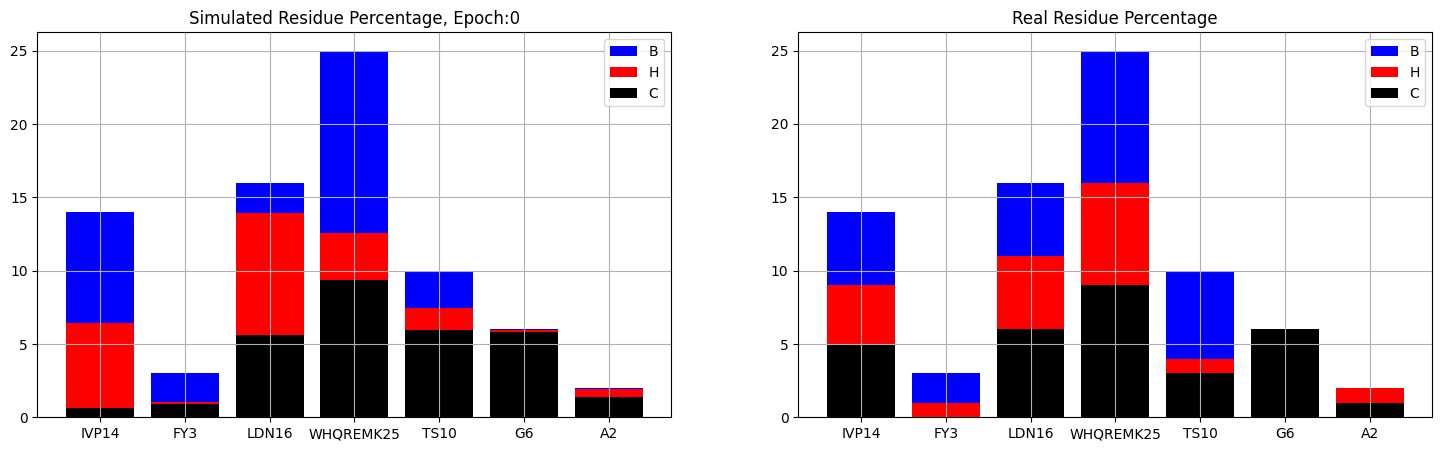

In [ ]:
# Experimental Feature Below

sub_groups = ['IVP', 'FY', 'LDN', 'WHQREMK', 'TS', 'G', 'A', 'C'] # The subgroups can be made into individual residues, or groups of residues

residue_distribution_grouped(model.soft_a.detach().cpu().numpy(),
                             index = 0,
                             sequence = sequence,
                             groups = sub_groups,
                             real_ss =  real_ss )

# Create Custom Plots

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

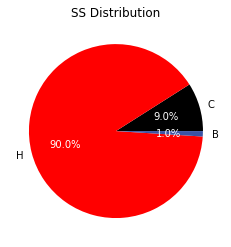

In [ ]:
#@title Create Custom Distribution
Percent_Beta = 0.01#@param {type:"number"}
Percent_Helix =  0.9#@param {type:"number"}
Plot_Name = "CustomPlot" #@param {type:"string"}
Download_File = True #@param {type:"boolean"}
#@markdown Note: Plot name should not contain space(s). If Download_File is checked, the file will be downloaded in eps format.
Percent_Coil = 1 - (Percent_Beta + Percent_Helix)
filename = '/content/' + Plot_Name + '.eps'

[Percent_Coil, Percent_Helix, Percent_Beta]
colors = ['black', 'red', '#3A53A4']
_, _, autotexts = plt.pie([Percent_Coil, Percent_Helix, Percent_Beta], explode=[0.001,0,0], labels=['C', 'H', 'B'], autopct='%1.1f%%',colors = colors);
for autotext in autotexts:
    autotext.set_color('white')
plt.title('SS Distribution');
plt.savefig(filename)

if(Download_File):
    files.download(filename)